In [1]:
from keras import backend as K  
K.set_learning_phase(1) #set learning phase

from keras.applications import MobileNet #Xception #ResNet50
import h5py
# VGG16, VGG19, ResNet, and MobileNet all accept 224×224 input images,
# Inception V3 and Xception require 299×299
img_height=224 #299
img_width=224 #299
model = MobileNet(include_top=False, input_shape=(img_width,img_height,3))
#model.load_weights('/home/ubuntu/.keras/models/mobilenet_1_0_224_tf_no_top.h5')
print(model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense

# freeze previous layers
for layer in model.layers:
    layer.trainable = False #True 

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
#top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid')) #15, activation='softmax'))
new_model = Model(inputs=model.input, outputs=top_model(model.output))
model = new_model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [3]:
# Visualize model
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
#plot_model(model, show_shapes=True, to_file='model.png')

In [3]:
from keras import optimizers
lr=1e-4 #0.1
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=lr, momentum=0.9), metrics=['accuracy']) #optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [86]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint
filepath="weights.best.mobilenet.20171231.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# early stopping
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
# callbacks list
callbacks_list = [checkpoint]#,early_stopping]

In [81]:
import os
import glob
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import one_hot
from keras.applications.mobilenet import preprocess_input

def get_montgomery_shenzhen_class(img_path):
    finding = img_path.split('.')[0][-3]#[-1]
    if finding == '1':
        return 1
    else:
        return 0

def get_class(img_path):
    class_dir = img_path.split('/')[2]
    if class_dir == 'No Finding':
        return [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
    elif class_dir == 'Atelectasis':
        return [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Cardiomegaly':
        return [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Consolidation':
        return [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Edema':
        return [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Effusion':
        return [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Emphysema':
        return [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
    elif class_dir == 'Fibrosis':
        return [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
    elif class_dir == 'Hernia':
        return [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
    elif class_dir == 'Infiltration':
        return [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
    elif class_dir == 'Mass':
        return [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
    elif class_dir == 'Nodule':
        return [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
    elif class_dir == 'Pleural_Thickening':
        return [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
    elif class_dir == 'Pneumonia':
        return [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
    elif class_dir == 'Pneumothorax':
        return [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
    else:
        print("Unknown class: " + class_dir)
        return [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

def get_data(images_dir):
    imgs = []
    labels = []
    #all_img_paths = glob.glob(os.path.join(images_dir, 'Cardiomegaly/processed/*.*'))
    all_img_paths = glob.glob(os.path.join(images_dir, 'processed/*.*'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        img = load_img(img_path, target_size=(img_width, img_height))
        # convert the image pixels to a numpy array
        img = img_to_array(img)
        # prepare the image for the model
        img = preprocess_input(img)
        label = get_montgomery_shenzhen_class(img_path) #get_class(img_path)
        imgs.append(img)
        labels.append(label)
    return np.array(imgs), np.array(labels)

montgomery_X_train, montgomery_y_train = get_data('MontgomerySet/CXR_png/train') 
shenzhen_X_train, shenzhen_y_train = get_data('ChinaSet_AllFiles/CXR_png/train') 
X_train = np.concatenate((montgomery_X_train,shenzhen_X_train), axis=0)
y_train = np.concatenate((montgomery_y_train,shenzhen_y_train), axis=0)
print(X_train.shape)
print(y_train.shape)
montgomery_X_valid, montgomery_y_valid = get_data('MontgomerySet/CXR_png/valid') 
shenzhen_X_valid, shenzhen_y_valid = get_data('ChinaSet_AllFiles/CXR_png/valid') 
X_valid = np.concatenate((montgomery_X_valid,shenzhen_X_valid), axis=0)
y_valid = np.concatenate((montgomery_y_valid,shenzhen_y_valid), axis=0)
print(X_valid.shape)
print(y_valid.shape)
#X_test, y_test = get_data('images/test') 
#print(X_test.shape)
#print(y_test.shape)

(722, 224, 224, 3)
(722,)
(78, 224, 224, 3)
(78,)


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True, 
    preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

batch_size=16

train_generator = train_datagen.flow_from_directory(
    'images/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'images/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 5594 images belonging to 15 classes.
Found 692 images belonging to 15 classes.


In [88]:
#nb_train_samples = 2000
#nb_validation_samples = 800
epochs = 84
batch_size=32
# Fit the model
#model.fit_generator(
#    train_generator,
#    steps_per_epoch=nb_train_samples // batch_size,
#    epochs=epochs,
#    validation_data=validation_generator,
#    validation_steps=nb_validation_samples // batch_size,
#    callbacks=callbacks_list,
#    verbose=1)
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_valid,y_valid),callbacks=callbacks_list,verbose=1)

Train on 722 samples, validate on 78 samples
Epoch 1/84
722/722 [==============================] - 291s - loss: 0.7531 - acc: 0.6482 - val_loss: 0.9573 - val_acc: 0.6026
Epoch 2/84
722/722 [==============================] - 276s - loss: 0.4560 - acc: 0.8047 - val_loss: 1.0429 - val_acc: 0.5897
Epoch 3/84
722/722 [==============================] - 276s - loss: 0.2004 - acc: 0.9211 - val_loss: 1.2148 - val_acc: 0.5769
Epoch 4/84
722/722 [==============================] - 276s - loss: 0.0894 - acc: 0.9751 - val_loss: 1.0212 - val_acc: 0.6410
Epoch 5/84
722/722 [==============================] - 277s - loss: 0.0570 - acc: 0.9903 - val_loss: 0.7393 - val_acc: 0.7308
Epoch 6/84
722/722 [==============================] - 276s - loss: 0.0374 - acc: 0.9958 - val_loss: 0.7401 - val_acc: 0.7179
Epoch 7/84
722/722 [==============================] - 277s - loss: 0.0334 - acc: 0.9986 - val_loss: 0.6999 - val_acc: 0.7308
Epoch 8/84
722/722 [==============================] - 277s - loss: 0.0224 - acc:

722/722 [==============================] - 276s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.3639 - val_acc: 0.8718
Epoch 65/84
722/722 [==============================] - 276s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.3639 - val_acc: 0.8846
Epoch 66/84
722/722 [==============================] - 276s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.3629 - val_acc: 0.8718
Epoch 67/84
722/722 [==============================] - 276s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.3628 - val_acc: 0.8718
Epoch 68/84
722/722 [==============================] - 276s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3645 - val_acc: 0.8718
Epoch 69/84
722/722 [==============================] - 276s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3663 - val_acc: 0.8718
Epoch 70/84
722/722 [==============================] - 276s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3643 - val_acc: 0.8718
Epoch 71/84
722/722 [==============================] - 276s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3577 - val_acc: 0.8846
Epoc

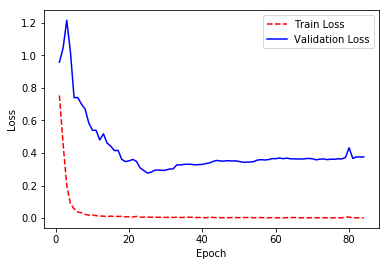

In [98]:
%matplotlib inline
from matplotlib import pyplot as plt

# Visualize loss history (requires history=model.fit... above)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [4]:
# save weights only
#model.save_weights('weights.best.mobilenet.20171217.hdf5')
# load weights only
model.load_weights("weights.best.mobilenet.20171231.hdf5")

# save entire model
#model.save('one-epoch-entire-model.h5')
# load entire model
#from keras.models import load_model
#model = load_model('one-epoch-entire-model.h5')
#model.summary()

In [20]:
import os
import glob
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import one_hot
from keras.applications.mobilenet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_montgomery_shenzhen_class(img_path):
    finding = img_path.split('.')[0][-3]#[-1]
    if finding == '1':
        return 1
    else:
        return 0

def batch_evaluate_prepare(images_dir):
    img_paths = []
    imgs = []
    labels = []
    predictions = []
    all_img_paths = glob.glob(os.path.join(images_dir, 'processed/*.*'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        img = load_img(img_path, target_size=(img_width, img_height))
        img_arr = img_to_array(img)
        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        label = get_montgomery_shenzhen_class(img_path)
        prediction = model.predict(img)
        img_paths.append(img_path)
        imgs.append(img_arr)
        predictions.append(prediction)
        labels.append(label)
    return np.array(img_paths), np.array(imgs), np.array(labels), np.array(predictions)

def batch_evaluate(img_paths, X_train, y_train, predictions):
    count = 0
    q75, q25 = np.percentile(predictions, [75 ,25])
    print("q75: " + str(q75))
    print("q25: " + str(q25))
    for img in range(len(X_train)):
        label = y_train[count]
        prediction = predictions[count][0][0]
        confident = True if ((label == 0 and prediction < q25) or (label == 1 and prediction > q75)) else False
        print(img_paths[count]+"\n"+"actual: " + str(label) + ", prediction: " + str(prediction) + ", confident? " + str(confident))
        #plt.figure()
        #plt.imshow(np.asarray(X_train[count]))
        #plt.suptitle(img_paths[count]+"\n"+"actual: " + str(label) + ", prediction: " + str(prediction) + ", confident? " + str(confident))
        count = count+1
    
montgomery_img_paths, montgomery_X_train, montgomery_y_train, montgomery_predictions = batch_evaluate_prepare('MontgomerySet/CXR_png/valid')
batch_evaluate(montgomery_img_paths, montgomery_X_train, montgomery_y_train, montgomery_predictions)

shenzhen_img_paths, shenzhen_X_train, shenzhen_y_train, shenzhen_predictions = batch_evaluate_prepare('ChinaSet_AllFiles/CXR_png/valid')
batch_evaluate(shenzhen_img_paths, shenzhen_X_train, shenzhen_y_train, shenzhen_predictions)


q75: 0.459942996502
q25: 0.0313779376447
MontgomerySet/CXR_png/valid/processed/MCUCXR_0393_1-p.png
actual: 1, prediction: 0.278038, confident? False
MontgomerySet/CXR_png/valid/processed/MCUCXR_0100_0-p.png
actual: 0, prediction: 0.0313779, confident? False
MontgomerySet/CXR_png/valid/processed/MCUCXR_0097_0-p.png
actual: 0, prediction: 0.179743, confident? False
MontgomerySet/CXR_png/valid/processed/MCUCXR_0103_0-p.png
actual: 0, prediction: 0.00593926, confident? True
MontgomerySet/CXR_png/valid/processed/MCUCXR_0101_0-p.png
actual: 0, prediction: 0.0302292, confident? True
MontgomerySet/CXR_png/valid/processed/MCUCXR_0099_0-p.png
actual: 0, prediction: 0.459943, confident? False
MontgomerySet/CXR_png/valid/processed/MCUCXR_0399_1-p.png
actual: 1, prediction: 0.976978, confident? True
MontgomerySet/CXR_png/valid/processed/MCUCXR_0095_0-p.png
actual: 0, prediction: 0.0340013, confident? False
MontgomerySet/CXR_png/valid/processed/MCUCXR_0096_0-p.png
actual: 0, prediction: 0.423016, co

In [21]:
scores = model.evaluate(X_valid, y_valid, verbose=1)
print("combined %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
montgomery_scores = model.evaluate(montgomery_X_valid, montgomery_y_valid, verbose=1)
print("montgomery %s: %.2f%%" % (model.metrics_names[1], montgomery_scores[1]*100))
shenzhen_scores = model.evaluate(shenzhen_X_valid, shenzhen_y_valid, verbose=1)
print("shenzhen %s: %.2f%%" % (model.metrics_names[1], shenzhen_scores[1]*100))

78/78 [==============================] - 12s    
combined acc: 91.03%
13/13 [==============================] - 2s
montgomery acc: 84.62%
65/65 [==============================] - 10s    
shenzhen acc: 92.31%


[[ 0.05817913]]


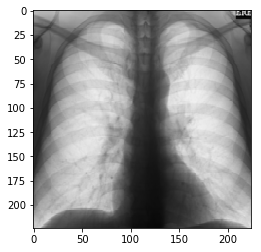

In [97]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import load_img
# load an image from file
img_path = 'MontgomerySet/CXR_png/valid/processed/MCUCXR_0102_0-p.png' #' #'images/test/Fibrosis/00002395_036.png'
image = load_img(img_path, target_size=(img_width, img_height))

from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

plt.figure()
plt.imshow(np.asarray(image))

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

from keras.applications.mobilenet import preprocess_input
# prepare the image for the model
image = preprocess_input(image)

# predict the probability across all output classes
predictions = model.predict(image)
print(predictions)

# select category with the highest probability
#import numpy as np
#print(np.argmax(predictions))

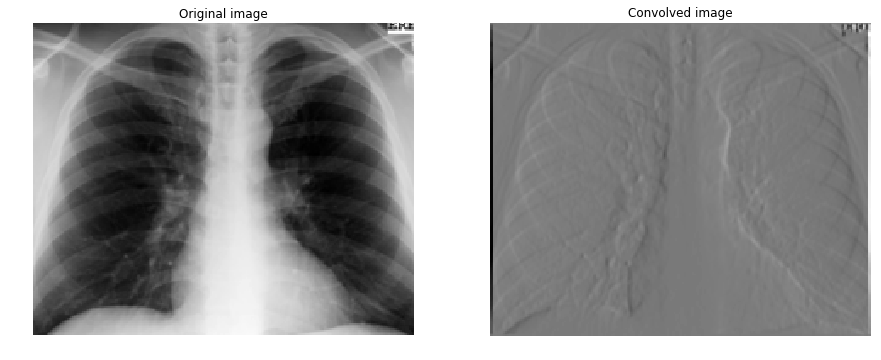

In [39]:
%matplotlib inline
from scipy.signal import convolve2d
import numpy as np 
import cv2
from matplotlib import pyplot as plt

# load an image from file
#img_path = 'MontgomerySet/CXR_png/valid/processed/MCUCXR_0102_0-p.png'
#image = load_img(img_path, target_size=(img_width, img_height))
#from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
#image = img_to_array(image)

image = cv2.imread('MontgomerySet/CXR_png/valid/processed/MCUCXR_0102_0-p.png')
# converting the image to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def show_differences(kernel):
    convolved = convolve2d(image, kernel)
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.title('Original image')
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    
    plt.subplot(122)
    plt.title('Convolved image')
    plt.axis('off')
    plt.imshow(convolved, cmap='gray')
    return convolved

# box blur
#kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9
#output = show_differences(kernel)
# edge detection
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
dx = show_differences(kernel)

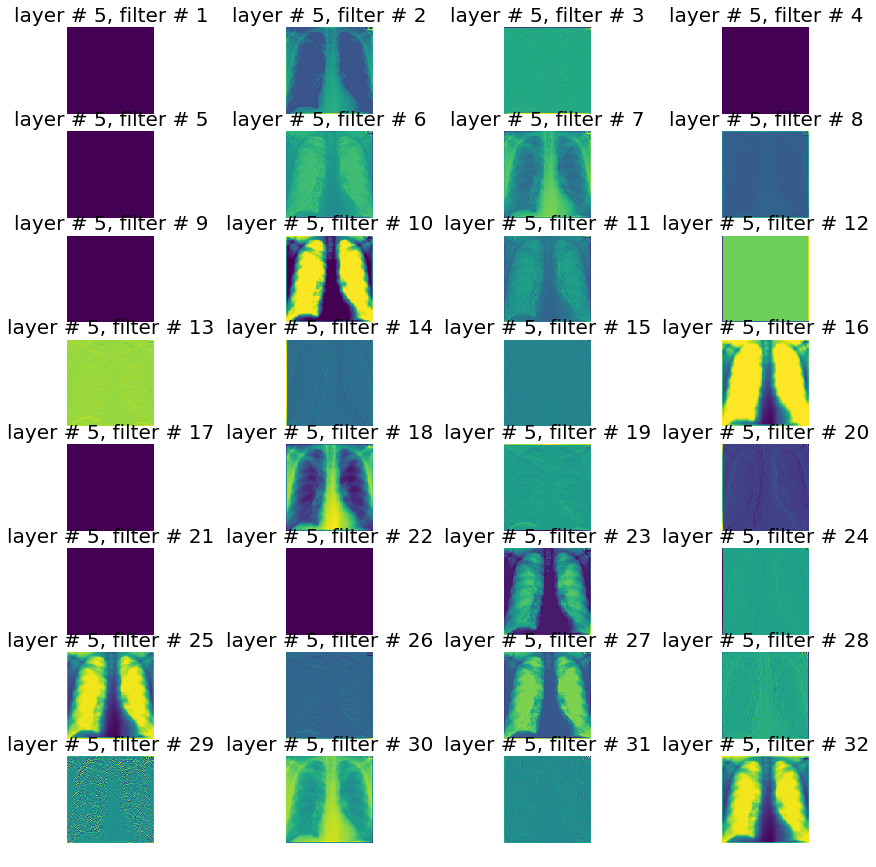

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import load_img, img_to_array

def get_layer_outputs(image):
    '''This function extracts the numerical output of each layer.'''
    outputs = []
    names = []
    count=0;
    for layer in model.layers:
        #print(model.get_config()['layers'][count]['inbound_nodes'])
        #print(layer.get_config())
        if layer.name == 'conv_pw_13_relu':
            outputs.append(layer.output)
            names.append(layer.name)
            break
        else:
            outputs.append(layer.output) #.get_output_at(count)) #output)
            names.append(layer.name)
            count = count+1
    #outputs    = [layer.output for layer in model.layers] 
    comp_graph = [K.function([model.input] + [K.learning_phase()], [output]) for output in outputs]

    # Feeding the image
    layer_outputs_list = [op([[image]]) for op in comp_graph]

    layer_outputs = []
    for layer_output in layer_outputs_list:
        #print(np.array(layer_output).shape, end='\n-------------------\n')
        layer_outputs.append(layer_output[0][0])

    return names, layer_outputs

def plot_layer_outputs(image, layer_number):
    '''This function handels plotting of the layers'''
    names, layer_outputs = get_layer_outputs(image)

    x_max = layer_outputs[layer_number].shape[0]
    y_max = layer_outputs[layer_number].shape[1]
    n     = layer_outputs[layer_number].shape[2]

    L = []
    for i in range(n):
        L.append(np.zeros((x_max, y_max)))

    for i in range(n):
        for x in range(x_max):
            for y in range(y_max):
                L[i][x][y] = layer_outputs[layer_number][x][y][i]

    #fig = plt.figure()
    fig = plt.figure(figsize=(15, 15))
    #plt.rcParams["figure.figsize"] = (30, 50)

    count = 0
    for img in L:
        a = fig.add_subplot((n/4),4,count+1)
        #plt.figure()
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')
        a.set_title(("layer # " + str(layer_number) + ", filter # " + str(count+1)), fontsize=20)
        count = count+1

#image = cv2.imread('MontgomerySet/CXR_png/valid/processed/MCUCXR_0102_0-p.png')
# converting the image to grayscale
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_path = 'MontgomerySet/CXR_png/valid/processed/MCUCXR_0102_0-p.png' #' #'images/test/Fibrosis/00002395_036.png'
image = load_img(img_path, target_size=(img_width, img_height))
image = img_to_array(image)
#print(image.shape)
#print(len(model.layers))
plot_layer_outputs(image, 5) #70)